In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
import torch

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [61]:
df = pd.read_csv("dataset/train.csv")
df.sample(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
34362,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37967,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25604,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6684,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34996,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
X = df.drop(columns=["label"]).to_numpy()
y = df["label"].to_numpy()

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 28, 28).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)

In [65]:
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 1, 28, 28).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)

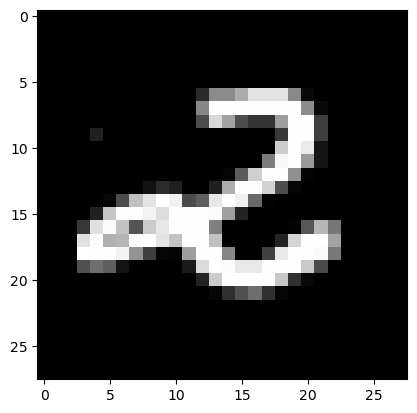

In [66]:
plt.imshow(X_train[0].cpu().squeeze(), cmap="gray")

In [67]:
from torch.utils.data import Dataset, DataLoader

class MNISTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx], self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [68]:
from torchvision import transforms

transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.ToTensor()
])

In [69]:
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)

In [70]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [154]:
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ELU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128),
    nn.BatchNorm1d(128),
    nn.ELU(),
    nn.Dropout(0.5),
    nn.Linear(128, 32),
    nn.ELU(),
    nn.Dropout(0.5),
    nn.Linear(32, 10)
).to(device)

In [155]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=0.001)

In [156]:
criterion = nn.CrossEntropyLoss()

In [157]:
num_epochs = 50

train_losses = []
val_losses = []

train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=1) == y_batch).float().mean()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_acc += (y_pred.argmax(dim=1) == y_batch).float().mean()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch + 1}/{num_epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}")

Epoch 1/50, train loss: 0.3091, val loss: 0.0713, train acc: 0.9193, val acc: 0.9774
Epoch 2/50, train loss: 0.1426, val loss: 0.0521, train acc: 0.9601, val acc: 0.9835
Epoch 3/50, train loss: 0.1170, val loss: 0.0430, train acc: 0.9675, val acc: 0.9870
Epoch 4/50, train loss: 0.0977, val loss: 0.0455, train acc: 0.9730, val acc: 0.9878
Epoch 5/50, train loss: 0.0843, val loss: 0.0423, train acc: 0.9757, val acc: 0.9865
Epoch 6/50, train loss: 0.0792, val loss: 0.0426, train acc: 0.9782, val acc: 0.9881
Epoch 7/50, train loss: 0.0718, val loss: 0.0450, train acc: 0.9796, val acc: 0.9874
Epoch 8/50, train loss: 0.0710, val loss: 0.0406, train acc: 0.9800, val acc: 0.9885
Epoch 9/50, train loss: 0.0579, val loss: 0.0400, train acc: 0.9833, val acc: 0.9903
Epoch 10/50, train loss: 0.0558, val loss: 0.0416, train acc: 0.9839, val acc: 0.9889
Epoch 11/50, train loss: 0.0559, val loss: 0.0404, train acc: 0.9848, val acc: 0.9892
Epoch 12/50, train loss: 0.0496, val loss: 0.0412, train acc: 0

In [160]:
torch.save(model.state_dict(), "models/model.pth")

In [158]:
train_accs = [acc.item() for acc in train_accs]
val_accs = [acc.item() for acc in val_accs]

print(f"Max train accuracy: {max(train_accs)} at epoch {train_accs.index(max(train_accs)) + 1}")
print(f"Max val accuracy: {max(val_accs)} at epoch {val_accs.index(max(val_accs)) + 1}")

Max train accuracy: 0.994523823261261 at epoch 50
Max val accuracy: 0.9918013215065002 at epoch 41


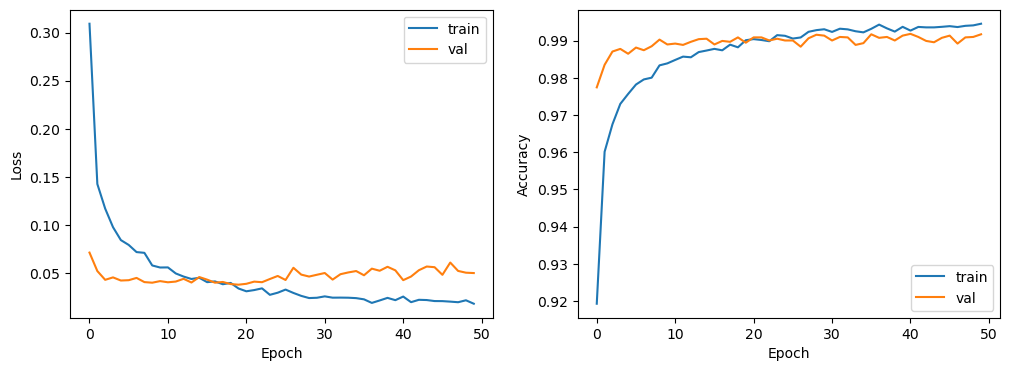

In [159]:
# Plot losses and accuracies
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [161]:
df_test = pd.read_csv("dataset/test.csv")
df_test.sample(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
5200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
X_test = df_test.to_numpy()
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 28, 28).to(device)


In [163]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1)

In [164]:
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(y_pred) + 1),
    "Label": y_pred.cpu().numpy()
})
submission.to_csv("submission.csv", index=False)